<a href="https://colab.research.google.com/github/felixv99/genai-runner/blob/main/images_to_code_multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/thesis'

Mounted at /content/drive


In [2]:


import json
import os

def get_json_from_drive(full_path):
  try:
    with open(full_path, 'r') as f:
      data = json.load(f)
      return data
      # Now you can work with the coco_data dictionary
      #print(coco_data) # Example: print the entire JSON data

  except FileNotFoundError:
    print(f"Error: File not found at {full_path}")
  except json.JSONDecodeError:
    print(f"Error: Invalid JSON format in {full_path}")
  except Exception as e:
    print(f"An unexpected error occurred: {e}")


coco_file_path = os.path.join(base_path,'result.json')
paired_file_path = os.path.join(base_path,'paired_images.json')
coco_data = get_json_from_drive(coco_file_path)
paired_data = get_json_from_drive(paired_file_path)


In [3]:

import pandas as pd

images_df = df = pd.json_normalize(paired_data, sep='_')
categories_df = pd.DataFrame(coco_data['categories'])
annotations_df = pd.DataFrame(coco_data['annotations'])

print("Images DataFrame:")
print(images_df.head())  # Print the first few rows of the images DataFrame

print("\nCategories DataFrame:")
print(categories_df.head())  # Print the first few rows of the categories DataFrame

print("\nAnnotations DataFrame:")
print(annotations_df.head())  # Print the first few rows of the annotations DataFrame


Images DataFrame:
  id  img1_id           img1_file_name  img1_width  img1_height  img2_id  \
0  1        0  images\45284b90-1-1.png        1920         1080        1   
1  2        2  images\b37d9d6f-2-1.png        1920         1080        3   
2  3        4  images\2f982b6e-3-1.png        1920         1080        5   
3  4        6  images\f3c937a7-4-1.png        1920         1080        7   
4  5        8  images\1660e214-5-1.png        1920         1080        9   

            img2_file_name  img2_width  img2_height  
0  images\93e3cf51-1-2.png        1920         1080  
1  images\631eb68f-2-2.png        1920         1080  
2  images\42cc23b4-3-2.png        1920         1080  
3  images\09d515c5-4-2.png        1920         1080  
4  images\5cc01940-5-2.png        1920         1080  

Categories DataFrame:
   id                             name
0   0                             Area
1   1              Interactive element
2   2         Main interactive element
3   3  Repetitive inte

In [ ]:
import base64
from mimetypes import guess_type
import os

def get_full_img_path(img_file_name, mark=True):
      corrected_file_name = img_file_name.replace('\\', '/')

      if mark:
        name, ext = os.path.splitext(corrected_file_name)  # Split into name and extension
        corrected_file_name = f"{name}_mark{ext}"  # Add _mark before extension

      full_image_path = os.path.join(base_path, corrected_file_name)
      return full_image_path

# Function to encode a local image into data URL
def local_image_to_data_url(image_path):
    mime_type, _ = guess_type(image_path)
    # Default to png
    if mime_type is None:
        mime_type = 'image/png'

    # Read and encode the image file
    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

    # Construct the data URL
    return f"data:{mime_type};base64,{base64_encoded_data}"



###Save paired image ids as json

In [ ]:
import pandas as pd
import re

def create_image_pairs(df):
    """
    Create pairs of related images based on file names.

    Parameters:
    df (pandas.DataFrame): DataFrame containing image information with columns:
        - width
        - height
        - id
        - file_name

    Returns:
    pandas.DataFrame: DataFrame with paired images and their metadata
    """
    # Extract the sequence number from file names (the number before the last dash)
    df['pair_id'] = df['file_name'].apply(lambda x: re.search(r'.*?(\d+)-[12]\.png$', x).group(1))

    # Create separate DataFrames for images ending with -1 and -2
    df_1 = df[df['file_name'].str.endswith('-1.png')].copy()
    df_2 = df[df['file_name'].str.endswith('-2.png')].copy()

    # Rename columns to distinguish between image 1 and image 2
    df_1.columns = [f'img1_{col}' if col != 'pair_id' else col for col in df_1.columns]
    df_2.columns = [f'img2_{col}' if col != 'pair_id' else col for col in df_2.columns]

    # Merge the DataFrames based on pair_id
    paired_df = pd.merge(df_1, df_2, on='pair_id', how='inner')

    # Drop the temporary pair_id column
    #paired_df = paired_df.drop(['pair_id'], axis=1)

    return paired_df

# Example usage:

paired_df = create_image_pairs(images_df)
paired_df.head(5)
#paired_df.shape[0]


,img1_width,img1_height,img1_id,img1_file_name,pair_id,img2_width,img2_height,img2_id,img2_file_name
0,1920,1080,0,images\45284b90-1-1.png,1,1920,1080,1,images\93e3cf51-1-2.png
1,1920,1080,2,images\b37d9d6f-2-1.png,2,1920,1080,3,images\631eb68f-2-2.png
2,1920,1080,4,images\2f982b6e-3-1.png,3,1920,1080,5,images\42cc23b4-3-2.png
3,1920,1080,6,images\f3c937a7-4-1.png,4,1920,1080,7,images\09d515c5-4-2.png
4,1920,1080,8,images\1660e214-5-1.png,5,1920,1080,9,images\5cc01940-5-2.png


In [ ]:
import json

# First convert DataFrame to dictionary
df_dict = paired_df.to_dict('records')

# For nested structure, you might need to restructure the data
# If your columns are like 'info_age' and 'info_city':
nested_data = []
for row in df_dict:
    nested_row = {
        'id': row['pair_id'],
        'img1': {
            'id': row['img1_id'],
            'file_name': row['img1_file_name'],
            'width': row['img1_width'],
            'height': row['img1_height']
        },
        'img2': {
            'id': row['img2_id'],
            'file_name': row['img2_file_name'],
            'width': row['img2_width'],
            'height': row['img2_height']
        }
    }
    nested_data.append(nested_row)

# Save to file with nice formatting
with open('/content/drive/MyDrive/thesis/paired_images.json', 'w') as f:
    json.dump(nested_data, f, indent=4)

###Draw bounding boxes and save as _mark

In [ ]:
Images = images_df
Annotations = annotations_df
#Categories = categories_df
Images

In [ ]:
import os
import cv2
import pandas as pd
import ast

# Base path in Google Colab
base_path = "/content/drive/MyDrive/thesis"

# Assuming the DataFrames Images, Categories, Annotations are already loaded

for _, image_row in Images.iterrows():
    image_id = image_row['id']
    file_name = image_row['file_name']

    # Correct file path separators for Linux environment in Colab
    corrected_file_name = file_name.replace('\\', '/')
    full_image_path = os.path.join(base_path, corrected_file_name)

    # Read the image using OpenCV
    img = cv2.imread(full_image_path)
    if img is None:
        print(f"Warning: Could not read image at {full_image_path}. Skipping...")
        continue

    # Get annotations for the current image with category_id 0
    annotations = Annotations[(Annotations['image_id'] == image_id) & (Annotations['category_id'] == 0)]

    # Draw each bounding box
    for _, ann in annotations.iterrows():
        bbox = ann['bbox']
        # Convert string representation of list to actual list if necessary
        if isinstance(bbox, str):
            bbox = ast.literal_eval(bbox)
        # Ensure the bbox has at least 4 elements (x, y, width, height)
        if len(bbox) < 4:
            print(f"Invalid bbox {bbox} for annotation {ann['id']}. Skipping...")
            continue
        x, y, w, h = map(int, bbox[:4])
        # Draw the rectangle on the image
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 4)

    # Construct the new file name with _mark
    original_name, extension = os.path.splitext(corrected_file_name)
    new_file_name = f"{original_name}_mark{extension}"
    full_save_path = os.path.join(base_path, new_file_name)

    # Ensure the directory exists
    os.makedirs(os.path.dirname(full_save_path), exist_ok=True)

    # Save the image
    if not cv2.imwrite(full_save_path, img):
        print(f"Failed to save image at {full_save_path}")

print("Processing complete.")

Processing complete.


##Generation

In [4]:
!pip install -U langchain langchain-anthropic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.2/223.2 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.18
    Uninstalling langchain-0.3.18:
      Successfully uninstalled langchain-0.3.18


In [5]:
import os
from google.colab import userdata
os.environ['LANGSMITH_TRACING'] = "true"
os.environ['LANGSMITH_ENDPOINT'] ="https://api.smith.langchain.com"
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
os.environ['LANGSMITH_PROJECT'] = "thesis-jupyter"
os.environ['ANTHROPIC_API_KEY'] = userdata.get('ANTHROPIC_API_KEY')

In [6]:
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", max_tokens=4092)

In [7]:
from langsmith import Client

client = Client()

In [11]:
generation_type = "chain" #naive or chain

In [44]:
##Naive generation
naive_prompt = client.pull_prompt("naive-prompt")
model_generate_code = llm
chain = naive_prompt | model_generate_code

In [45]:
##Enhanced generation
prompt1 = client.pull_prompt("test-chain-pt1")
prompt2 = client.pull_prompt("test-chain-pt2")
prompt3 = client.pull_prompt("test-chain-pt3")
model_generate_analysis = prompt1 | llm
model_generate_code = prompt2 | llm
model_improve_code = prompt3 | llm

chain = { "ANALYSIS": model_generate_analysis, "CODE": model_generate_code } | model_improve_code

In [20]:
test = chain.invoke({},config={"img_pair_id": "testing123"})

In [ ]:
test.to_json()

In [ ]:
import uuid
import json
import os

class Generation:
    def __init__(self, pair_id, gen_type, llm_response):
        self.id = str(uuid.uuid4())
        self.pair_id = pair_id
        self.gen_type = gen_type
        self.llm_responses = [llm_response]

    def to_dict(self):
        return {
            "id": self.id,
            "pair_id": self.pair_id,
            "type": self.gen_type,
            "llm_responses": self.llm_responses
        }

def load_generations(filename="generations.json"):
    filename = os.path.join(base_path,filename)
    if os.path.exists(filename):
        with open(filename, "r") as f:
            try:
                return json.load(f)
            except json.JSONDecodeError:
                return []
    else:
        return []

def save_generations(generations, filename="generations.json"):
    with open(os.path.join(base_path,filename), "w") as f:
        json.dump(generations, f, indent=4)

In [ ]:
paired = images_df.iloc[2:]
for _, image_row in paired.iterrows():
    img1_path = get_full_img_path(image_row['img1_file_name'])
    img2_path = get_full_img_path(image_row['img2_file_name'])
    img1_data = local_image_to_data_url(img1_path)
    img2_data = local_image_to_data_url(img2_path)
    img_pair_id = image_row['id']

    response = chain.invoke({"SCREENSHOT_1": img1_data, "SCREENSHOT_2": img2_data}, config={"img_pair_id": img_pair_id})
    response_json = response.to_json()
    response_json["content_type"] = "code"

    new_generation = Generation(img_pair_id, "naive", response_json)

    # Load current data
    generations = load_generations()

    # Append new generation
    generations.append(new_generation.to_dict())

    # Save back to file
    save_generations(generations)

    print(f"Saved generation {img_pair_id}")

Saved generation 3
Saved generation 4
Saved generation 5
Saved generation 6
Saved generation 7
Saved generation 8
Saved generation 9
Saved generation 10
Saved generation 11
Saved generation 12
Saved generation 13
Saved generation 14
Saved generation 15
Saved generation 16
Saved generation 17
Saved generation 18
Saved generation 19
Saved generation 20


###Querying traces for later

In [36]:
project_runs = client.list_runs(
project_name="thesis-jupyter",
filter="and(eq(metadata_key, 'img_pair_id'), eq(metadata_value, 'testing123'))",
run_type="llm"
)

In [37]:
runs = list(project_runs)
runs

[<class 'langsmith.schemas.Run'>(id=ac4190c3-197d-42ec-b0db-759cf55c9729, name='ChatAnthropic', run_type='llm'),
 <class 'langsmith.schemas.Run'>(id=53b4682c-a331-4d2f-953e-6491106dfb19, name='ChatAnthropic', run_type='llm'),
 <class 'langsmith.schemas.Run'>(id=3b459477-0754-42e1-99b2-0ca8197e6852, name='ChatAnthropic', run_type='llm')]

In [40]:
runs[0].json()

'{"id": "ac4190c3-197d-42ec-b0db-759cf55c9729", "name": "ChatAnthropic", "start_time": "2025-02-20T12:32:23.359523", "run_type": "llm", "end_time": "2025-02-20T12:32:24.425486", "extra": {"batch_size": 1, "inputs_is_truthy": true, "invocation_params": {"_type": "anthropic-chat", "default_request_timeout": null, "max_retries": 2, "max_tokens": 4092, "model": "claude-3-5-sonnet-20241022", "model_kwargs": {}, "stop": null, "streaming": false, "temperature": null, "top_k": null, "top_p": null}, "metadata": {"LANGSMITH_ENDPOINT": "https://api.smith.langchain.com", "LANGSMITH_PROJECT": "thesis-jupyter", "LANGSMITH_TRACING": "true", "img_pair_id": "testing123", "ls_max_tokens": 4092, "ls_model_name": "claude-3-5-sonnet-20241022", "ls_model_type": "chat", "ls_provider": "anthropic", "ls_temperature": null}, "options": {"stop": null}, "runtime": {"langchain_core_version": "0.3.35", "langchain_version": "0.3.19", "library": "langsmith", "platform": "Linux-6.1.85+-x86_64-with-glibc2.35", "py_impl

###temp tests2

In [ ]:
chain = prompt | model_generate_code
response = chain.invoke({"SCREENSHOT_INITIAL": img1_data, "SCREENSHOT_AFTER_INTERACTION": img2_data}, config={"img_pair_id": img_pair_id})
response

In [ ]:
prompt.to_json()

In [ ]:
response_json = response.to_json()
response_json["content_type"] = "code"
response_json

###temp tests

HumanMessage(content=[{'type': 'text', 'text': 'What is in this image?'}, {'type': 'image_url', 'image_url': {'url': ''}}], additional_kwargs={}, response_metadata={})
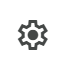

In [ ]:
from langchain_core.messages import HumanMessage
message = HumanMessage(content=[
        {"type": "text", "text": "What is in this image?"},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/png;base64,{image_data}"},
        },
    ],
)
message

In [ ]:
llm.invoke([message], config={"component_id": "test"})

AIMessage(content="This image shows a simple gear or cog icon/symbol. It's a common symbol used to represent settings, tools, configurations, or mechanical/technical functions in user interfaces and applications.", additional_kwargs={}, response_metadata={'id': 'msg_012ZzLTuwT7imqqZrxS2tLDr', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 25, 'output_tokens': 41}}, id='run-cca685a6-3fe6-4521-86c4-80073141300a-0', usage_metadata={'input_tokens': 25, 'output_tokens': 41, 'total_tokens': 66, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})